<a href="https://colab.research.google.com/github/hanyoseob/lecture_optimization/blob/main/chapter14_Performance_evaluation_for_medical_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performace evaluation for natural image processing
---
Until now, we have learned various optimization methods such as [a gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent), [a newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), and [a conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method).

Here, we will compare a  CT reconstruction performance accoding to the optimization methods.

Its optimization problem is formulated as:

> $x^* = \arg \min_{x} F(x)$,

where a fidelity term $F(x)$ is defined as $\frac{1}{2} || Ax - y ||_2^2$, a system matrix $A$ denotes [Radon transform](https://en.wikipedia.org/wiki/Radon_transform) ( = projection operation ), $y$ is sinogram measured from the system matrix $A$, and $x$ is a reconstructed image.

Importantly, except for the system matrix $A$ such as the Gaussian kernel that handles ___natural image processing___ and the projection operation that handles ___medical image processing___, both problems can be solved without changing the optimization problem. In other words, regardless of the domains such as natural image and medical image, the solution of the inverse problem can be found by solving the optimization problem if we know the system matrix $A$ and its transpose matrix $A^T$.


## Optimization methods
---
1. [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
2. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
3. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

###[Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
---
> $x_{n+1} = x_n - \lambda_n \nabla F(x_n)$,

where $F(\cdot)$ and $\nabla F(\cdot)$ are any objective function and its derivative function, respectively, and $\lambda_n$ is step size.


###[Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
---
> $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$,

where $f(\cdot)$ and $f'(\cdot)$ are the function trying to find the roots ( or zeros ) and its derivative, respectively.

###[Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)
---
Suppose we want to solve the system of linear equations
> $Ax=b$,

for the vector $x$, where the known $n \times n$ matrix $A$ is symmetric (i.e., $A^T = A$), positive-definite (i.e., $x^TAx > 0$ for all non-zero vectors $x \in \mathbb{R}^n$), and real, and $b$ is known as well. We denote the unique solution of this system by $x^*$.

> $r_0 := b - Ax_0$
>
> if $r_0$ is sufficiently small, then return $x_0$ as the result
>
> $p_0 := r_0$
> 
> k := 0
> 
> repeat
>
>> $a_k := \frac{r_k^Tr_k}{p_k^TAp_k}$
>> 
>> $x_{k+1} := x_k + \alpha_kp_k$
>>
>> $r_{k+1} := r_k - \alpha_kAp_k$
>>
>> if $r_{k+1}$ is sufficiently small, then exit loop
>>
>> $\beta_k := \frac{r_{k+1}^Tr_{k+1}}{r_k^Tr_k}$
>>
>> $p_{k+1} := r_{k+1} + \beta_k p_k$
>>
>> k := k + 1
>
> end repeat
>
> return $x_{k+1}$ as the result

# Implementation
---

1. Problem definition
2. Functionalization of optimization methods
3. Execution of optimization methods

## Problem definition
---
1. Objective function $F(x)$
> $F(x) = \frac{1}{2} || Ax - y ||_2^2$

2. its derivative $\nabla F(x)$
> $\nabla F(x) = A^T(Ax - y)$


##Execution of optimization methods
---
1. Add packages
2. Set Set the system matrix $A$ and its transpose $A^T$
3. Define the optimization methods
4. Run the [inverse radon transform](https://en.wikipedia.org/wiki/Radon_transform) $A^{-1}$
5. Run the optimization methods

### Add packages

In [1]:
# Mathmetical packages
import numpy as np
from scipy.signal import convolve

# Image processing package
from skimage import data
from skimage.transform import resize

# CT processing package
from skimage.transform import radon, iradon

# Metrics calculating packages
from skimage.metrics import normalized_root_mse as compare_nmse
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Ploting packages
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# Ploting options
font = {'family': 'normal',
        'weight': 'bold',
        'size': 10}

matplotlib.rc('font', **font)


### Set the system matrix $A$ and its transpose $A^T$

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


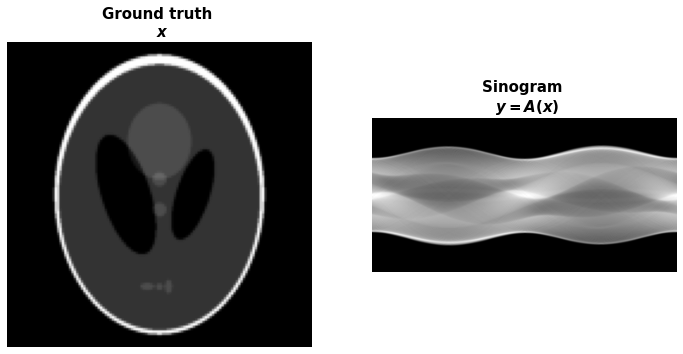

In [2]:
# Load the clean image x ( = ground truth ) 
N = 128   # size of image
M = N

# Shepp logan phantom is a default phantom in the CT field
x_gt = data.shepp_logan_phantom().astype(dtype=np.float64)
x_gt = resize(x_gt, output_shape=(N, N))

# Set the CT system parameters
VIEW = 360
THETA = np.linspace(0, 360, VIEW, endpoint=False)

# Define the System operator (A) and its transpose (AT)
# A: Projection operation ( = radon transform )
# AT: Backprojection operation without the filtration ( = iradon transform w\o filtration )
A = lambda x: radon(x, theta=THETA, circle=False)
AT = lambda y: iradon(y, theta=THETA, circle=False, output_size=N, filter=None) / (np.pi / (2.0 * VIEW))

DCT = A(np.zeros_like(x_gt)).shape[0]

# Generate the output y from the system operator A
y = A(x_gt)

# Plot the images
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))

axs[0].imshow(x_gt, vmin=0, vmax=1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Ground truth \n $x$', fontsize=15, fontweight='bold')

axs[1].imshow(y, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Sinogram \n $y = A(x)$', fontsize=15, fontweight='bold')

plt.show()


### Define the optimization methods
---
1. Set the general parameters
2. [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
3. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
4. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

####Set the general parameters
---

In [3]:
# F: Objective function
# dF: Its derivative
F = lambda x: 1/2 * np.sum( (A(x) - y) ** 2 ) ** 1/2
dF = lambda x: AT( A(x) - y )

# The number of iterations
max_iter = 300

####[Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
---

In [4]:
# Hyper parameters for the gradient descent method
step_size_gd = 1e-5

In [5]:
def gradient_descent_method(x, dF, F, step_size=1e-1, max_iter=100, is_figure=False):
  y_iter = []

  for i in range(1, max_iter + 1):

    # Grdient descent method
    x = x - step_size * dF(x)

    y_iter.append(F(x))

    # Plot the results from gradient descent method
    if is_figure and ((i + 1) % 10) == 0 or (i + 1) == max_iter:
      # Plot the result from gradient descent method
      fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
      ax = axs[0]
      pcm = ax.imshow(x, cmap='gray', vmin=0, vmax=1)
      ax.set_title('%d-th result from gradient descent method' % (i + 1), fontsize=15, fontweight='bold')
      # fig.colorbar(pcm, ax=ax)

      # Plot a curve of the objective function
      ax = axs[1]
      ax.semilogy(y_iter, 'r--', linewidth=3)
      ax.grid(True)
      ax.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
      # ax.set_ylabel('Objective function', fontsize=15, fontweight='bold')
      ax.set_title('$x^*$ = arg $\min_x 1/2 || Ax - y ||^2_2$', fontsize=15, fontweight='bold')

      display.clear_output(wait=True)
      plt.show()

  return x, y_iter

####[Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
---

In [6]:
# f: The function trying to find the roots ( or zeros ) ( = dF )
# df: Its derivative
f_newton = lambda x: AT( A(x) - y )
df_newton = lambda x: AT( A(np.ones_like(x)) )


In [7]:
def newtons_method(x, f, df, F, max_iter=100, is_figure=False):
  y_iter = []

  for i in range(1, max_iter + 1):

    # Newton's method
    x = x - f(x) / df(x)

    y_iter.append(F(x))

    # Plot the results from newton's method
    if is_figure and ((i + 1) % 10) == 0 or (i + 1) == max_iter:
      # Plot the result from newton's method
      fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
      ax = axs[0]
      pcm = ax.imshow(x, cmap='gray', vmin=0, vmax=1)
      ax.set_title('%d-th result from newton\'s method' % (i + 1), fontsize=15, fontweight='bold')
      # fig.colorbar(pcm, ax=ax)

      # Plot a curve of the objective function
      ax = axs[1]
      ax.semilogy(y_iter, 'r--', linewidth=3)
      ax.grid(True)
      ax.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
      # ax.set_ylabel('Objective function', fontsize=15, fontweight='bold')
      ax.set_title('$x^*$ = arg $\min_x 1/2 || Ax - y ||^2_2$', fontsize=15, fontweight='bold')

      display.clear_output(wait=True)
      plt.show()

  return x, y_iter

#### [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)
---

In [8]:
# A_cg: The system matrix to apply the conjugate gradient method
# b: Its measurement (CONSTANT VALUES)
A_cg = lambda x: AT( A(x) )
b_cg = AT(y)


In [9]:
def conjugate_gradient_method(x, A, b, max_iter=100, is_figure=False):
  y_iter = []

  # Search the solution using the conjugate gradient method
  # r = b - np.matmul(A, x)
  r = b - A_cg(x)
  p = r
  # rs_old = np.matmul(r.T, r)
  rs_old = np.matmul(r.reshape(1, -1), r.reshape(-1, 1))

  for i in range(1, max_iter + 1):
    # Ap = np.matmul(A, p)
    Ap = A_cg(p)

    # alpha = rs_old / np.matmul(p.T, Ap)
    alpha = rs_old / (np.matmul(p.reshape(1, -1), Ap.reshape(-1, 1)))
    
    x = x + alpha * p
    r = r - alpha * Ap

    # rs_new = np.matmul(r.T, r)
    rs_new = np.matmul(r.reshape(1, -1), r.reshape(-1, 1))

    if np.sqrt(rs_new) < 1e-10:
      y_iter.append(F(x))
      break

    p = r + (rs_new / rs_old) * p
    rs_old = rs_new

    y_iter.append(F(x))

    # Plot the results from conjugate gradient method
    if is_figure and ((i + 1) % 10) == 0 or (i + 1) == max_iter:
      # Plot the result from newton's method
      fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
      ax = axs[0]
      pcm = ax.imshow(x, cmap='gray', vmin=0, vmax=1)
      ax.set_title('%d-th result from conjugate gradient method' % (i + 1), fontsize=15, fontweight='bold')
      # fig.colorbar(pcm, ax=ax)

      # Plot a curve of the objective function
      ax = axs[1]
      ax.semilogy(y_iter, 'r--', linewidth=3)
      ax.grid(True)
      ax.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
      # ax.set_ylabel('Objective function', fontsize=15, fontweight='bold')
      ax.set_title('$x^*$ = arg $\min_x 1/2 || Ax - y ||^2_2$', fontsize=15, fontweight='bold')

      display.clear_output(wait=True)
      plt.show()

  return x, y_iter

### Run the inverse radon transform ( = Filtered Backprojection; FBP ) $A^{-1}$
---

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


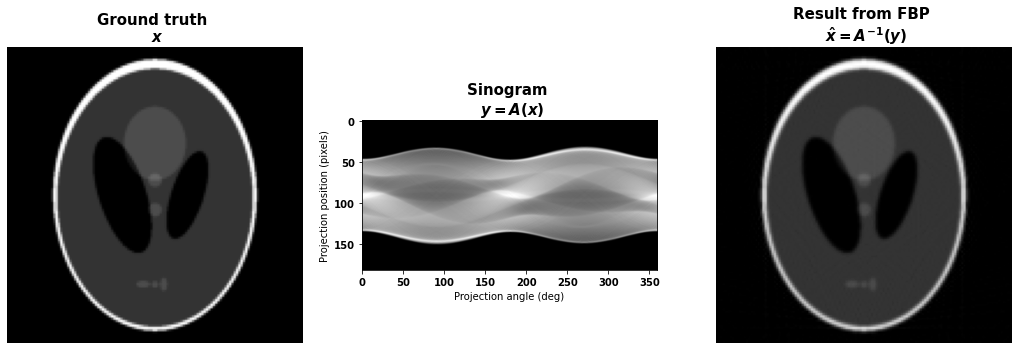

Result from Filtered Backprojection
NSME: 1.3676e-01
PSNR: 29.9304
SSIM: 0.9806


In [10]:
# A^-1: Filtered Backprojection (FBP) operation ( = iradon transform )
AINV = lambda y: iradon(y, theta=THETA, circle=False, output_size=N, filter='ramp')

# Filtered Backprojection (FBP)
x = AINV(y)

# Plot the images
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 8))

ax = axs[0]
ax.imshow(x_gt, vmin=0, vmax=1, cmap='gray')
ax.set_title('Ground truth \n $x$', fontsize=15, fontweight='bold')
ax.axis('off')

ax = axs[1]
ax.imshow(y, cmap='gray')
ax.set_title('Sinogram \n $y = A(x)$', fontsize=15, fontweight='bold')
ax.set_xlabel("Projection angle (deg)")
ax.set_ylabel("Projection position (pixels)")
# axs[1].axis('off')

ax = axs[2]
ax.imshow(x, vmin=0, vmax=1, cmap='gray')
ax.set_title('Result from FBP \n $\hat{x} = A^{-1}(y)$', fontsize=15, fontweight='bold')
ax.axis('off')

plt.show()

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_est_fbp = x

nmse_fbp = compare_nmse(x_gt, x_est_fbp)
psnr_fbp = compare_psnr(x_gt, x_est_fbp)
ssim_fbp = compare_ssim(x_gt, x_est_fbp)

print('Result from Filtered Backprojection')
print('NSME: %.4e' % nmse_fbp)
print('PSNR: %.4f' % psnr_fbp)
print('SSIM: %.4f' % ssim_fbp)

### Run the optimization methods
---
1. [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
2. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
3. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

#### [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)

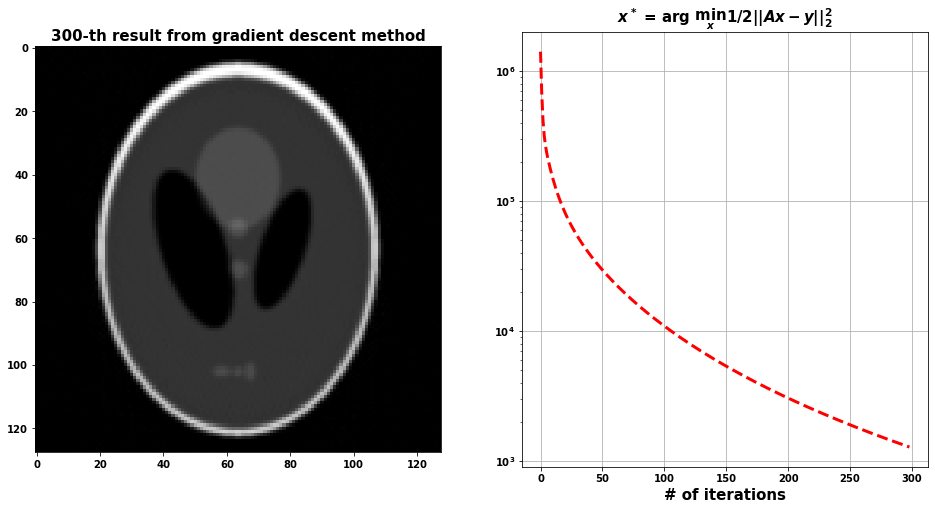

Result from gradient descent method
NSME: 1.5458e-01
PSNR: 28.8664
SSIM: 0.9794


In [11]:
# Initiate image x
x = np.zeros((N, M))

# Run gradient descent method
x_est_gd, loss_gd = gradient_descent_method(x, dF, F, step_size=step_size_gd, max_iter=max_iter, is_figure=True)

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
nmse_gd = compare_nmse(x_gt, x_est_gd)
psnr_gd = compare_psnr(x_gt, x_est_gd)
ssim_gd = compare_ssim(x_gt, x_est_gd)

print('Result from gradient descent method')
print('NSME: %.4e' % nmse_gd)
print('PSNR: %.4f' % psnr_gd)
print('SSIM: %.4f' % ssim_gd)

#### [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)

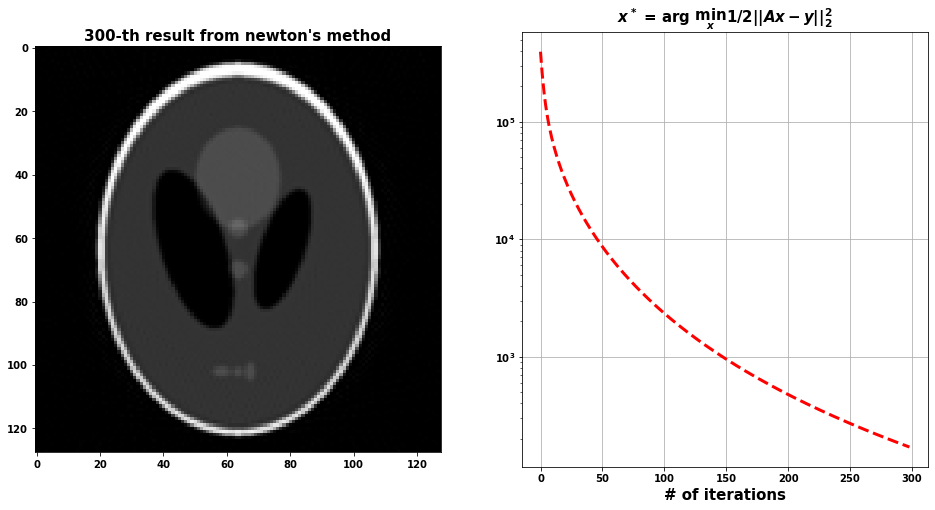

Result from newton's method
NSME: 8.6494e-02
PSNR: 33.9096
SSIM: 0.9894


In [12]:
# Initiate image x
x = np.zeros((N, M))

# Run Newton's method
x_est_newton, loss_newton = newtons_method(x, f_newton, df_newton, F, max_iter=max_iter, is_figure=True)

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
nmse_newton = compare_nmse(x_gt, x_est_newton)
psnr_newton = compare_psnr(x_gt, x_est_newton)
ssim_newton = compare_ssim(x_gt, x_est_newton)

print('Result from newton\'s method')
print('NSME: %.4e' % nmse_newton)
print('PSNR: %.4f' % psnr_newton)
print('SSIM: %.4f' % ssim_newton)

####  [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

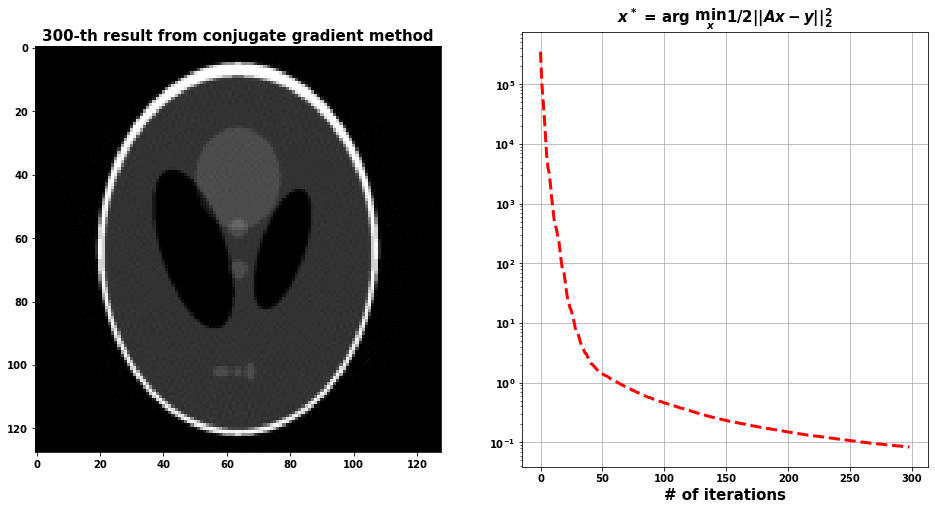

Result from conjugate gradient method
NSME: 2.4020e-02
PSNR: 45.0379
SSIM: 0.9952


In [13]:
# Initiate image x
x = np.zeros((N, M))

# Run conjugate gradient method
x_est_cg, loss_cg = conjugate_gradient_method(x, A_cg, b_cg, max_iter=max_iter, is_figure=True)

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
nmse_cg = compare_nmse(x_gt, x_est_cg)
psnr_cg = compare_psnr(x_gt, x_est_cg)
ssim_cg = compare_ssim(x_gt, x_est_cg)

print('Result from conjugate gradient method')
print('NSME: %.4e' % nmse_cg)
print('PSNR: %.4f' % psnr_cg)
print('SSIM: %.4f' % ssim_cg)

# Results
___

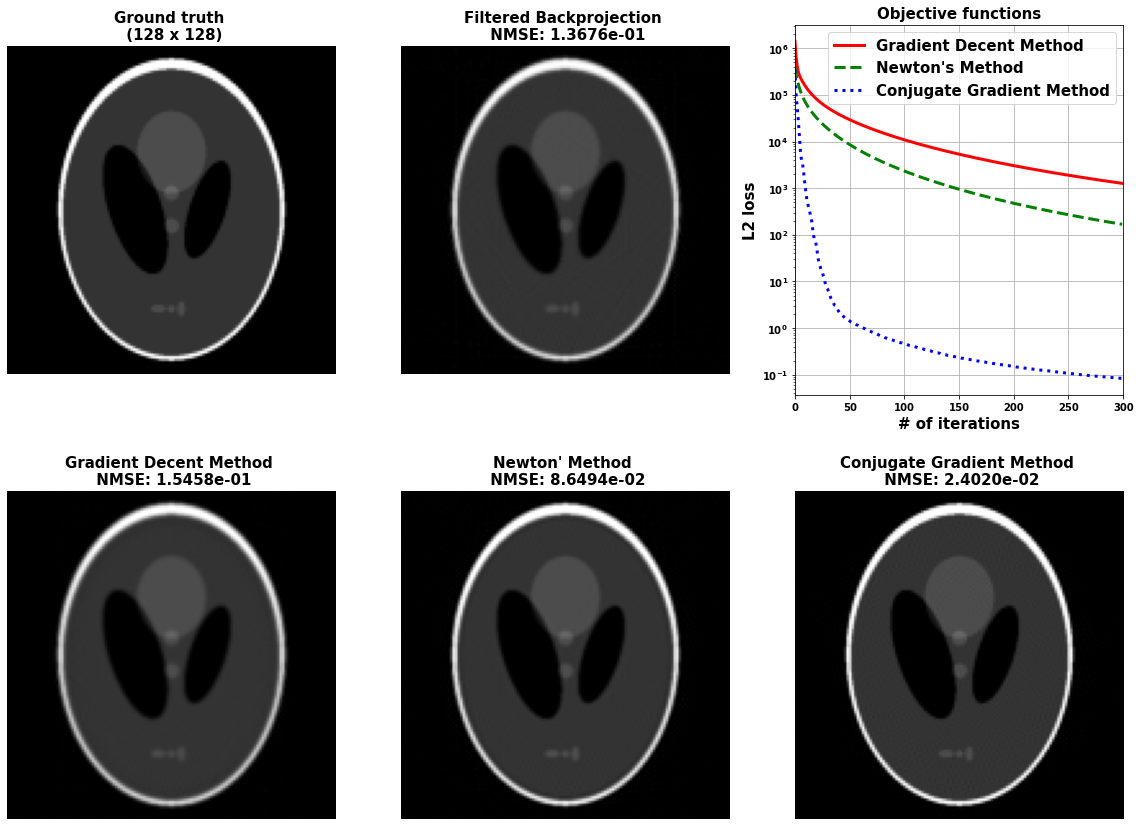

 
Quantitative metrics
 
Normalized  Mean Sqaure Error (NMSE)
Filtered Backprojection    : 1.3676e-01
Gradient descent method    : 1.5458e-01
Newton's method            : 8.6494e-02
Conjugate gradient method  : 2.4020e-02
 
Peak Signal to Noise Ratio (PSNR)
Filtered Backprojection    : 29.9304
Gradient descent method    : 28.8664
Newton's method            : 33.9096
Conjugate gradient method  : 45.0379
 
Structural Similarity Index Measure (SSIM)
Filtered Backprojection    : 0.9806
Gradient descent method    : 0.9794
Newton's method            : 0.9894
Conjugate gradient method  : 0.9952
 


In [19]:
# Plot the results from gradient descent method, newton's method, and conjugate gradient method
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 15))

ax = axs[0, 0]
ax.imshow(x_gt, vmin=0, vmax=1, cmap='gray')
ax.axis('off')
ax.set_title('Ground truth \n (%d x %d)' % (N, M), fontsize=15, fontweight='bold')

ax = axs[0, 1]
ax.imshow(x_est_fbp, vmin=0, vmax=1, cmap='gray')
ax.axis('off')
ax.set_title('Filtered Backprojection \n NMSE: %.4e' % (nmse_fbp), fontsize=15, fontweight='bold')

ax = axs[0, 2]
ax.semilogy(loss_gd, 'r-', label='Gradient Decent Method', linewidth=3)
ax.semilogy(loss_newton, 'g--', label='Newton\'s Method', linewidth=3)
ax.semilogy(loss_cg, 'b:', label='Conjugate Gradient Method', linewidth=3)
ax.legend(fontsize=15)
ax.grid(True)
ax.set_xlim((0, max_iter))
ax.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
ax.set_ylabel('L2 loss', fontsize=15, fontweight='bold')
ax.set_title('Objective functions', fontsize=15, fontweight='bold')


axs[1, 0].imshow(x_est_gd, vmin=0, vmax=1, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Gradient Decent Method \n NMSE: %.4e' % (nmse_gd), fontsize=15, fontweight='bold')

axs[1, 1].imshow(x_est_newton, vmin=0, vmax=1, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Newton\' Method \n NMSE: %.4e' % (nmse_newton), fontsize=15, fontweight='bold')

axs[1, 2].imshow(x_est_cg, vmin=0, vmax=1, cmap='gray')
axs[1, 2].axis('off')
axs[1, 2].set_title('Conjugate Gradient Method \n NMSE: %.4e' % (nmse_cg), fontsize=15, fontweight='bold')

plt.show()

# Print the quantitative metrics
print(' ')
print('Quantitative metrics')
print(' ')

print('Normalized  Mean Sqaure Error (NMSE)')
print('Filtered Backprojection    : %.4e' % nmse_fbp)
print('Gradient descent method    : %.4e' % nmse_gd)
print('Newton\'s method            : %.4e' % nmse_newton)
print('Conjugate gradient method  : %.4e' % nmse_cg)
print(' ')

print('Peak Signal to Noise Ratio (PSNR)')
print('Filtered Backprojection    : %.4f' % psnr_fbp)
print('Gradient descent method    : %.4f' % psnr_gd)
print('Newton\'s method            : %.4f' % psnr_newton)
print('Conjugate gradient method  : %.4f' % psnr_cg)
print(' ')

print('Structural Similarity Index Measure (SSIM)')
print('Filtered Backprojection    : %.4f' % ssim_fbp)
print('Gradient descent method    : %.4f' % ssim_gd)
print('Newton\'s method            : %.4f' % ssim_newton)
print('Conjugate gradient method  : %.4f' % ssim_cg)
print(' ')


# Conclusion

In this chapter, we covered ___the deblurring problem___, which is the ___realistic___ and ___practical___ problems in a natural image processing. Above figures show the results from [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function), [a gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent), [a newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), and [the conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method). Specifically, [the conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) provides an high-enhanced image quality and its quantitative metrics are significantly improved than other methods like [a gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent) and [a newton's method](https://en.wikipedia.org/wiki/Newton%27s_method).

#References
---

1. [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
2. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
3. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)
4. [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)


# Next
---

Next chapter, we will summarize all the optimization methods such as the [gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent), [newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), and [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method), and review their performance through the medical image processing.